# Imports

In [17]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
from transformers import BertTokenizer, BertModel
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import functional as F
import bz2
import nltk
import re
import torch.optim as optim
import torch.nn as nn
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import random
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from itertools import product
from sklearn.utils.class_weight import compute_class_weight
random.seed(42)

[nltk_data] Downloading package punkt to /home/rize/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/rize/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/rize/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Paths to directories (update these paths as necessary)
root_dir = '/home/rize/deep_assignments/NLP'

# Extract Data

In [ ]:
# Extract and save the decompressed content to a new file
# with bz2.open('heldout_op_data.jsonlist.bz2', 'rt') as compressed_file:
#     with open('heldout_op_data.jsonlist', 'w') as decompressed_file:
#         decompressed_file.write(compressed_file.read())

# with bz2.open('train_op_data.jsonlist.bz2', 'rt') as compressed_file:
#     with open('train_op_data.jsonlist', 'w') as decompressed_file:
#         decompressed_file.write(compressed_file.read())

with bz2.open(f'{root_dir}/pair_task/heldout_pair_data.jsonlist.bz2', 'rt') as compressed_file:
    with open(f'{root_dir}/pair_task/heldout_pair_data.jsonlist', 'w') as decompressed_file:
        decompressed_file.write(compressed_file.read())

with bz2.open(f'{root_dir}/pair_task/train_pair_data.jsonlist.bz2', 'rt') as compressed_file:
    with open(f'{root_dir}/pair_task/train_pair_data.jsonlist', 'w') as decompressed_file:
        decompressed_file.write(compressed_file.read())

with bz2.open(f'{root_dir}/all/heldout_period_data.jsonlist.bz2', 'rt') as compressed_file:
    with open(f'{root_dir}/all/heldout_period_data.jsonlist', 'w') as decompressed_file:
        decompressed_file.write(compressed_file.read())

with bz2.open(f'{root_dir}/all/train_period_data.jsonlist.bz2', 'rt') as compressed_file:
    with open(f'{root_dir}/all/train_period_data.jsonlist', 'w') as decompressed_file:
        decompressed_file.write(compressed_file.read())

# EDA

### Analyze op data set (original post)

- delta_label" shows whether the OP changed her opinion (True if she changed her mind, False if not).

- "selftext" and "title" provide textual information

- "name" is an identifier that can be used to find more submission-related information in the corresponding file in all/.

In [ ]:
# Create Combined DataFrames
test_df = pd.read_json('heldout_period_data.jsonlist', lines=True)
train_df = pd.read_json('train_period_data.jsonlist', lines=True)
combined_df = pd.concat([test_df, train_df])

KeyboardInterrupt: 

In [ ]:
op_test_df = pd.read_json('heldout_op_data.jsonlist', lines=True)
op_train_df = pd.read_json('train_op_data.jsonlist', lines=True)
op_combined_df = pd.concat([op_test_df, op_train_df])

In [ ]:
# pair_test_df = pd.read_json('heldout_pair_data.jsonlist', lines=True)
# pair_train_df = pd.read_json('train_pair_data.jsonlist', lines=True)
# pair_combined_df = pd.concat([pair_test_df, pair_train_df])

In [ ]:
op_combined_df.info()

In [ ]:
op_combined_df.head()

In [ ]:
print('Proportion of persuasion')
op_combined_df['delta_label'].value_counts(normalize=True)

In [ ]:
sns.countplot(x='delta_label', data=op_combined_df)
plt.title('Count of persuasion')
plt.show()

In [ ]:
print('Number of different authors: ', op_combined_df['name'].nunique())

In [ ]:
# Function to calculate average token count with and without stop words for a DataFrame column
def calculate_avg_tokens_column(df, column_name):
    stop_words = set(stopwords.words('english'))

    token_counts_with_stopwords = []
    token_counts_without_stopwords = []

    for text in df[column_name].dropna():
        if isinstance(text, str):  # Ensure the value is a valid string
            tokens = word_tokenize(text.lower())  # Tokenize and lowercase the text
            tokens_without_stopwords = [token for token in tokens if token not in stop_words]

            token_counts_with_stopwords.append(len(tokens))
            token_counts_without_stopwords.append(len(tokens_without_stopwords))

    # Calculate the averages
    avg_with_stopwords = sum(token_counts_with_stopwords) / len(token_counts_with_stopwords)
    avg_without_stopwords = sum(token_counts_without_stopwords) / len(token_counts_without_stopwords)

    return avg_with_stopwords, avg_without_stopwords

# Perform the analysis on the 'op_title' column of the DataFrame
avg_with_stopwords_title, avg_without_stopwords_title = calculate_avg_tokens_column(op_combined_df, 'selftext')

print(f"Average token count with stop words in 'selftext': {avg_with_stopwords_title}")
print(f"Average token count without stop words in 'selftext': {avg_without_stopwords_title}")

### Analyze Pair data

- "positive" is a list of replies in a rooted path-unit that won a delta from OP, while "negative" is a matching rooted path-unit that did not win a delta.

- "op_author", "op_text", and "op_title" give information for the original post.

- "op_name" is an identifier that can be used to find more submission-related information in the corresponding file in all/.

In [10]:
# Load data set
pair_test_df = pd.read_json(f'{root_dir}/pair_task/heldout_pair_data.jsonlist', lines=True)
pair_train_df = pd.read_json(f'{root_dir}/pair_task/train_pair_data.jsonlist', lines=True)
pair_combined_df = pd.concat([pair_test_df, pair_train_df])

In [ ]:
pair_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4263 entries, 0 to 3455
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   op_author  4263 non-null   object
 1   op_text    4263 non-null   object
 2   op_title   4263 non-null   object
 3   positive   4263 non-null   object
 4   negative   4263 non-null   object
 5   op_name    4263 non-null   object
dtypes: object(6)
memory usage: 233.1+ KB


In [ ]:
pair_combined_df.head()

,op_author,op_text,op_title,positive,negative,op_name
0,923iwek,I'll start off by saying I'm a vegetarian and ...,CMV: The contribution of vegans/vegetarians an...,"{'ancestor': 't1_cundk5r', 'author': 'ghoooooo...","{'ancestor': 't1_cunbl8g', 'author': 'ClimateM...",t3_3j8yfq
1,923iwek,I'll start off by saying I'm a vegetarian and ...,CMV: The contribution of vegans/vegetarians an...,"{'ancestor': 't1_cunbkbz', 'author': 'archagon...","{'ancestor': 't1_cuncrke', 'author': 'Diomange...",t3_3j8yfq
2,Navyurf,"Hello, I'm Luke and for the longest time a sma...",CMV:I want to live in Scandinavia,"{'ancestor': 't1_cun0c3t', 'author': 'huadpe',...","{'ancestor': 't1_cun2oqr', 'author': 'iamambie...",t3_3j7dlx
3,trashlunch,"By ""practical reason,"" I mean a reason that mo...",CMV: There is no practical reason for any indi...,"{'ancestor': 't1_cumn3j4', 'author': 'ReOsIr10...","{'ancestor': 't1_cumqh8n', 'author': 'Omega037...",t3_3j64aa
4,VaginalExcrement,"\n_____\n\nAlright, so, i was challenged by a ...",CMV: We Should execute the weak to improve the...,"{'ancestor': 't1_cumhf65', 'author': 'BadKeyMa...","{'ancestor': 't1_cumi9vr', 'author': 'MCBeatho...",t3_3j5b7g


In [ ]:
pair_combined_df.iloc[2]['positive']['comments'][0]['id']

'cun0c3t'

Fields are identical for negative and positive, Interesting fields for each comment are:
- Score, up, and down metrics reflecting the comment's popularity and reception.
- controversiality, A score representing how divisive the comment is.
- body, The text content of the comment.

In [ ]:
print('Number of different OP authors: ', pair_combined_df['op_author'].nunique())
print('Number of original post per author: ')
pair_combined_df.groupby('op_author').size().describe()

Number of different OP authors:  2619
Number of original post per author: 


,0
count,2619.000000
mean,1.627721
std,1.285167
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,19.000000


In [ ]:
pair_combined_df.shape

(4263, 6)

In [ ]:

# Function to add new fields for the number of positive and negative comments
def add_comment_counts_json(df, positive_col, negative_col):
    num_positive = []
    num_negative = []

    for _, row in df.iterrows():
        try:
            # Access the 'comments' key directly from the dictionary
            positive_data = row[positive_col]
            negative_data = row[negative_col]

            # Count the number of comments
            num_positive.append(len(positive_data.get('comments', [])))
            num_negative.append(len(negative_data.get('comments', [])))
        except (json.JSONDecodeError, KeyError, TypeError):
            # Handle parsing errors or missing fields
            num_positive.append(0)
            num_negative.append(0)

    # Add the new columns to the DataFrame
    df['num_of_positive'] = num_positive
    df['num_of_negative'] = num_negative
    return df

# Add the new fields to the dataset
pair_data = add_comment_counts_json(pair_combined_df, 'positive', 'negative')

pair_data[['num_of_positive', 'num_of_negative']].describe()

,num_of_positive,num_of_negative
count,4263.000000,4263.000000
mean,1.422003,1.291344
std,0.747248,0.690852
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,1.000000
max,5.000000,5.000000


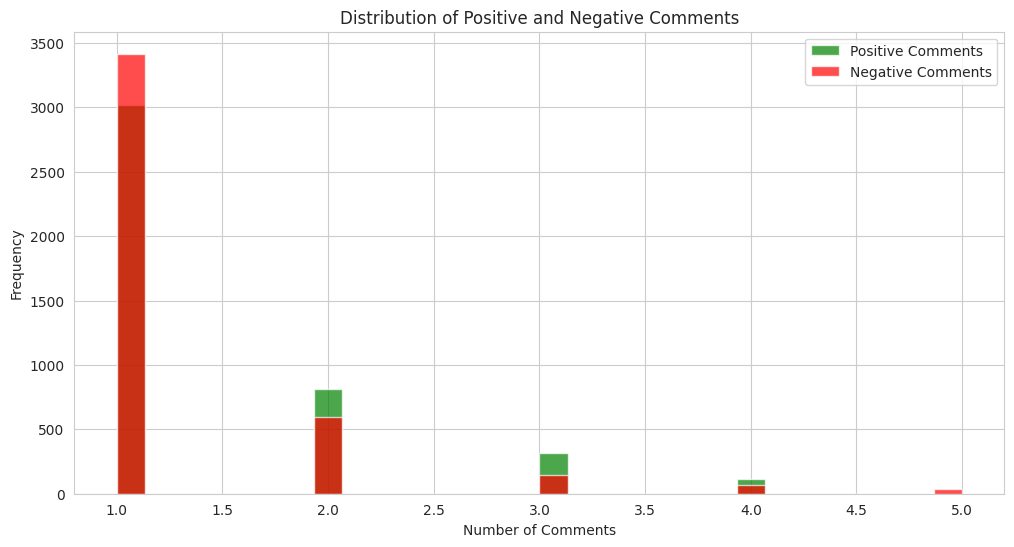

In [ ]:
# Plot the distribution of positive and negative comments
plt.figure(figsize=(12, 6))

# Distribution for positive comments
plt.hist(pair_data['num_of_positive'], bins=30, alpha=0.7, label='Positive Comments', color='green')

# Distribution for negative comments
plt.hist(pair_data['num_of_negative'], bins=30, alpha=0.7, label='Negative Comments', color='red')

# Add labels and title
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')
plt.title('Distribution of Positive and Negative Comments')
plt.legend()
plt.show()

In [ ]:
print('Example of discussion with title')
pair_combined_df.iloc[0]['op_title']

Example of discussion with title


'CMV: The contribution of vegans/vegetarians and other environmentally conscious people is absolutely insignificant.'

In [ ]:
print('Positive Example:')
pair_combined_df.iloc[0]['positive']['comments'][0]['body']

Positive Example:


'In short, the reality is: It adds up.\n\n[Does Veganism Make a Difference?](http://www.animalliberationfront.com/Philosophy/Utilitarianism/Does%20Veganism%20Make%20a%20Difference.htm)\n\n[Expected Utility, Contributory Causation, and Vegetarianism](http://www.veganoutreach.org/enewsletter/thresholds.pdf)\n\nBoth of these essays approach your question in a statistics-based manner that focuses on thresholds. They propose that your effect on meat production is a measurable probability.\n\nIn other words, they ask questions like, "What are the odds that your purchase of, say, a frozen turkey will be the one that causes your grocery store to order another entire shipment of frozen turkeys? And that that shipment causes the food distributor to order more turkeys? And that that shipment causes a farm to slaughter more turkeys?" \n\nThe number of animals produced and slaughtered is so high that the very small probability of you sparing an animal from it still translates to 50-100 animals per 

In [ ]:
print('Negative Example:')
pair_combined_df.iloc[0]['negative']['comments'][0]['body']

Negative Example:


"I agree with /u/huadpe that simply the act of being vegetarian/vegan makes it easier for other people to reduce their meat consumption, because as the population of vegetarians and vegans expands, restaurants are offering more and better vegetarian/vegan options, including some that are so tasty only the most rabid carnivores would turn their nose up at them. The growing number of people with vegetarian/vegan friends and family members also means that more people are being exposed to delicious vegetarian/vegan food and even learning how to cook it, all of which chips away at the all-too-common notion that any meal without meat isn't worth eating.\n\nHelping society at large reduce its meat consumption is really important because meat production has such an enormous environmental impact, especially with regard to climate change. The exact contribution of animal agriculture to climate change is disputed, but the most widely accepted statistics seem to put animal agriculture at about 15-

### Analyze period data (all data raw from reddit API)

In [ ]:
test_df.head()

,domain,banned_by,media_embed,subreddit,selftext_html,selftext,likes,suggested_sort,user_reports,secure_media,...,url,author_flair_text,quarantine,title,created_utc,distinguished,mod_reports,visited,num_reports,ups
0,self.changemyview,NaN,{},changemyview,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...","From what I understand, the only significant d...",NaN,NaN,[],NaN,...,http://www.reddit.com/r/changemyview/comments/...,1∆,False,CMV: The position of Vice President of the Uni...,1441131871,None,[],False,NaN,0
1,self.changemyview,NaN,{},changemyview,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",I'll start off by saying I'm a vegetarian and ...,NaN,NaN,[],NaN,...,http://www.reddit.com/r/changemyview/comments/...,None,False,CMV: The contribution of vegans/vegetarians an...,1441130982,None,[],False,NaN,326
2,self.changemyview,NaN,{},changemyview,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",Al Franken went on Jon Stewart [a few weeks ag...,NaN,NaN,[],NaN,...,http://www.reddit.com/r/changemyview/comments/...,None,False,CMV: Anti-discrimination law is discriminatory.,1441126567,None,[],False,NaN,23
3,self.changemyview,NaN,{},changemyview,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...","I'll be honest with you, I didn't even know ab...",NaN,NaN,[],NaN,...,http://www.reddit.com/r/changemyview/comments/...,None,False,"CMV: Nicki Minaj is in the wrong, not Miley.",1441121901,None,[],False,NaN,0
4,self.changemyview,NaN,{},changemyview,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",(Note: While this post is written from the poi...,NaN,NaN,[],NaN,...,http://www.reddit.com/r/changemyview/comments/...,None,False,"CMV: On online dating, if you don't want to ta...",1441120965,None,[],False,NaN,0


In [ ]:
test_df[['id', 'comments', 'author_flair_text']].head()

,id,comments,author_flair_text
0,3j90qv,"[{'subreddit_id': 't5_2w2s8', 'banned_by': Non...",1∆
1,3j8yfq,"[{'subreddit_id': 't5_2w2s8', 'banned_by': Non...",None
2,3j8n34,"[{'subreddit_id': 't5_2w2s8', 'banned_by': Non...",None
3,3j8bhs,"[{'subreddit_id': 't5_2w2s8', 'banned_by': Non...",None
4,3j895i,"[{'subreddit_id': 't5_2w2s8', 'banned_by': Non...",None


author_flair_text = Delta

In [ ]:
test_df.iloc[0]['comments'][0]

{'subreddit_id': 't5_2w2s8',
 'banned_by': None,
 'removal_reason': None,
 'link_id': 't3_3j90qv',
 'likes': None,
 'replies': {'kind': 'Listing',
  'data': {'modhash': '',
   'children': ['cunbngs'],
   'after': None,
   'before': None}},
 'user_reports': [],
 'saved': False,
 'id': 'cun9x23',
 'gilded': 0,
 'archived': False,
 'report_reasons': None,
 'author': 'draculabakula',
 'parent_id': 't3_3j90qv',
 'score': 1,
 'approved_by': None,
 'controversiality': 0,
 'body': 'The vice president often is called to act as a replacement for a duty or appearance if the president is not around. For instance, meeting foreign dignitaries if the president is out of town. There needs to be a second face of the executive branch.\n\nAlso, if the second in succession to the presidency was the speaker of the house, the opposing party might take it upon themselves to try and assassinate or impeach the president simply for the reason of taking over the executive branch. The position of vice president e

We can parse and build conversion tree for each post, usig the comments parent id.

# Preprocessing

In [3]:
# Step 1: Preprocessing - Load and Parse Data
def load_jsonlines(file_path):
    """Load data from a .jsonlist file."""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

In [5]:
pair_test_df = pd.read_json(f'{root_dir}/CMv data/pair_task/heldout_pair_data.jsonlist', lines=True)
pair_train_df = pd.read_json(f'{root_dir}/CMv data/pair_task/train_pair_data.jsonlist', lines=True)
pair_combined_df = pd.concat([pair_test_df, pair_train_df])

train_period_data = load_jsonlines(f"{root_dir}/CMv data/all/train_period_data.jsonlist")
heldout_period_data = load_jsonlines(f"{root_dir}/CMv data/all/heldout_period_data.jsonlist")

print(f"Size of all train data: {len(train_period_data)}, size of all test data: {len(heldout_period_data)}")
print(f"Size of pair train data: {len(pair_train_df)}, size of pair test data: {len(pair_test_df)}")

Size of all train data: 18363, size of all test data: 2263
Size of pair train data: 3456, size of pair test data: 807


In [6]:
def clean_selftext(text):
    """
    Remove the CMV rules section from the selftext field.
    """
    return text.split('*Hello, users of CMV!')[0]

# Step 2: Preprocessing - Extract Relevant Features
def preprocess_data(data):
    """Extract and clean relevant data."""
    processed_data = []
    for entry in data:
        submission = {
            "id": entry["id"],
            "name": entry["name"],
            "author": entry["author"],
            "author_flair_text": entry["author_flair_text"], # General number of deltas got in the CMV subreddit
            "ups": entry["ups"],
            "downs": entry["downs"],
            "num_comments": entry["num_comments"],
            "body": clean_selftext(entry["selftext"]),
            "title": entry["title"],
            "comments": entry['comments'],
        }
        processed_data.append(submission)
    return processed_data

In [7]:
train_processed = preprocess_data(train_period_data)
test_processed = preprocess_data(heldout_period_data)
len(train_processed), len(test_processed)

(18363, 2263)

In [8]:
# Extract positive comment IDs from pair data
positive_comment_ids = set()
negative_comment_ids = set()
for _, row in pair_combined_df[['positive', 'negative']].iterrows():  # Iterate through rows
    positives = row['positive']  # Access 'positive' column
    negatives = row['negative']  # Access 'negative' column
    for comment in positives["comments"]:
        positive_comment_ids.add(comment["id"])
    for comment in negatives["comments"]:
        negative_comment_ids.add(comment["id"])

len(positive_comment_ids), len(negative_comment_ids)

(6030, 4990)

In [9]:
pair_combined_df.iloc[0]

op_author                                              923iwek
op_text      I'll start off by saying I'm a vegetarian and ...
op_title     CMV: The contribution of vegans/vegetarians an...
positive     {'ancestor': 't1_cundk5r', 'author': 'ghoooooo...
negative     {'ancestor': 't1_cunbl8g', 'author': 'ClimateM...
op_name                                              t3_3j8yfq
Name: 0, dtype: object

In [10]:
# Flatten the comments for easy lookup and assign delta labels
all_comments = {}
op_names_set = set(pair_combined_df['op_name'])

for i, submission in enumerate(train_processed):
    if submission['name'] in op_names_set:
        all_comments[submission['id']] = submission
        all_comments[submission['id']]["delta"] = 0 

        for comment in submission["comments"]:
            comment_id = comment["id"]
            if comment_id not in all_comments:  # Avoid overwrites
                all_comments[comment_id] = comment
            # Assign delta label
            all_comments[comment_id]["delta"] = 1 if comment_id in positive_comment_ids else 0

for submission in test_processed:
    if submission['name'] in op_names_set:
        all_comments[submission['id']] = submission
        all_comments[submission['id']]["delta"] = 0 
        for comment in submission["comments"]:
            comment_id = comment["id"]
            if comment_id not in all_comments:  # Avoid overwrites
                all_comments[comment_id] = comment
            # Assign delta label
            all_comments[comment_id]["delta"] = 1 if comment_id in positive_comment_ids else 0

# Count labeled and unlabeled comments
delta_count = sum(comment["delta"] == 1 for comment in all_comments.values())
no_delta_count = sum(comment["delta"] == 0 for comment in all_comments.values())

print(f"Comments with delta: {delta_count}")
print(f"Comments without delta: {no_delta_count}")
print('Positive class ratio: ', delta_count / (delta_count + no_delta_count))

Comments with delta: 6030
Comments without delta: 287267
Positive class ratio:  0.02055936473949614


In [11]:
# Take only the graphs that has at least one delta in the comments
train_processed_reduced = [submission for submission in train_processed if submission['name'] in op_names_set]
test_processed_reduced = [submission for submission in test_processed if submission['name'] in op_names_set]

# Output the lengths of the filtered lists
len_train = len(train_processed_reduced)
len_test = len(test_processed_reduced)

print(f"Length of reduced train_processed: {len_train}")
print(f"Length of reduced test_processed: {len_test}")


Length of reduced train_processed: 2509
Length of reduced test_processed: 542


# Graph Construction

In [58]:
# Graph Construction
def standardize_node_id(node_id):
    """Remove Reddit-specific prefixes (t1_, t3_) from node IDs."""
    return node_id.split("_")[-1]

def build_basic_graph(root, comments, all_edges=False):
    """Build a conversation tree graph where each parent points to all its descendants."""
    graph = nx.DiGraph()
    
    # Filter comments and add the root node
    comment_ids, root_id, root_author, root_body = initialize_graph(graph, root, comments)

    # Add comment nodes and direct parent-child edges
    delta_nodes = add_nodes_and_edges(graph, comments, root_id, root_author, root_body, comment_ids)

    # Calculate distances from root to delta nodes
    delta_distances = calculate_delta_distances(graph, root_id, delta_nodes)

    # Add all descendant edges if specified
    if all_edges:
        add_descendant_edges(graph)

    # Update root node attributes
    update_root_node_attributes(graph, root_id, delta_nodes, delta_distances)

    return graph


def initialize_graph(graph, root, comments):
    """Initialize the graph by adding the root node and filtering comments."""
    comment_ids = {
        standardize_node_id(comment["id"]) for comment in comments if "author" not in comment or comment["author"] != 'DeltaBot'
    }
    root_id = standardize_node_id(root["id"])
    root_author = root.get("author", "Unknown")
    root_body = root.get("body", "")
    
    graph.add_node(
        root_id,
        text=root.get("body", ""),
        delta=0,
        root_id=root_id,
        root_body=root_body,
        author=root_author,
        ups=root.get("ups", 0),
        downs=root.get("downs", 0),
        node_type=0,
        author_flair_text=root.get("author_flair_text", 0),
        delta_count=0,  # Initialize delta count
        delta_distances=[],  # Initialize list for distances to delta nodes
    )
    comment_ids.add(root_id)

    return comment_ids, root_id, root_author, root_body

def add_nodes_and_edges(graph, comments, root_id, root_author, root_body, comment_ids):
    """Add nodes and direct parent-child edges to the graph."""
    delta_nodes = []
    
    for comment in comments:
        # Standardize node IDs
        node_id = standardize_node_id(comment["id"])
        parent_id = standardize_node_id(comment.get("parent_id", ""))
        
        # Skip DeltaBot comments
        if node_id not in comment_ids:
            continue

        # Add the current comment as a node
        comment_author = comment.get("author", "Unknown")
        delta_value = comment.get("delta", 0)
        graph.add_node(
            node_id,
            text=comment.get("body", ""),
            delta=delta_value,
            root_id=root_id,
            root_body=root_body,
            author=comment_author,
            ups=comment.get("ups", 0),
            downs=comment.get("downs", 0),
            node_type=0 if comment_author == root_author else 1,  # Add node type
            author_flair_text=comment.get("author_flair_text", 0),
        )

        # Track delta nodes
        if delta_value == 1:
            delta_nodes.append(node_id)

        # Add direct parent-child edge with distance = 1
        if parent_id and parent_id in comment_ids:
            graph.add_edge(parent_id, node_id, distance=1)
    
    return delta_nodes


def calculate_delta_distances(graph, root_id, delta_nodes):
    """Calculate the distances from the root node to delta nodes."""
    delta_distances = []
    for delta_node in delta_nodes:
        try:
            distance = nx.shortest_path_length(graph, source=root_id, target=delta_node)
            delta_distances.append(distance)
        except nx.NetworkXNoPath:
            pass  # Skip if no path exists
    return delta_distances


def add_descendant_edges(graph):
    """Add edges from each node to all its descendants."""
    for node in list(graph.nodes):
        descendants = nx.descendants(graph, node)  # Get all descendants
        for descendant in descendants:
            if not graph.has_edge(node, descendant):  # Avoid duplicate edges
                distance = nx.shortest_path_length(graph, source=node, target=descendant)
                graph.add_edge(node, descendant, distance=distance)  # Add distance as an attribute

def update_root_node_attributes(graph, root_id, delta_nodes, delta_distances):
    """Update the root node with delta count and distances."""
    graph.nodes[root_id]["delta_count"] = len(delta_nodes)
    graph.nodes[root_id]["delta_distances"] = delta_distances

In [47]:
def generate_color_map(authors):
    """Generate a unique color for each author."""
    colors = itertools.cycle(["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan", "magenta", "yellow", "black", "silver", "gold", "lime", "teal"])
    return {author: next(colors) for author in authors}

def visualize_graph_with_author_colors_and_labels(graph, figsize=(12, 8), title='Conversation Graph with Author Colors and Labels'):
    """Visualize the conversation graph with different colors for each author and custom labels."""
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(graph)  # Layout algorithm for positioning nodes

    # Extract all unique authors from the graph
    authors = {data["author"] for _, data in graph.nodes(data=True)}

    # Generate a color map for authors
    color_map = generate_color_map(authors)
    # Determine node colors based on the author
    node_colors = [color_map[data["author"]] for _, data in graph.nodes(data=True)]

    # Draw nodes with colors
    nx.draw_networkx_nodes(graph, pos, node_size=500, node_color=node_colors, alpha=0.8)

    # Draw edges
    nx.draw_networkx_edges(graph, pos, edge_color="gray", alpha=0.5)

    # Create custom labels
    labels = {}
    for node, data in graph.nodes(data=True):
        if data.get("delta", 0):  # Add delta sign for nodes with deltas
            labels[node] = "∆"
        elif data["root_id"] == node:  # Display root text for the root node
            labels[node] = "Root"  # Truncated root text
        else:
            labels[node] = data['author']  # No label for other nodes

    # Draw labels
    nx.draw_networkx_labels(graph, pos, labels, font_size=8, font_color="black")

    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.show()

def plot_delta_distribution(train_graphs, test_graphs):
    """
    Plot the distribution of the number of deltas in each graph for train and test sets.
    """
    # Extract delta counts for train and test graphs
    train_delta_counts = [
        graph.nodes[root]["delta_count"]
        for graph in train_graphs
        for root in graph.nodes
        if graph.nodes[root].get("root_id") == root  # Identify root nodes
    ]
    test_delta_counts = [
        graph.nodes[root]["delta_count"]
        for graph in test_graphs
        for root in graph.nodes
        if graph.nodes[root].get("root_id") == root  # Identify root nodes
    ]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Train distribution
    axes[0].hist(train_delta_counts, bins=20, color="skyblue", edgecolor="black")
    axes[0].set_title("Train Set")
    axes[0].set_xlabel("Number of Deltas")
    axes[0].set_ylabel("Frequency")

    # Test distribution
    axes[1].hist(test_delta_counts, bins=20, color="lightcoral", edgecolor="black")
    axes[1].set_title("Test Set")
    axes[1].set_xlabel("Number of Deltas")

    # Adjust layout and show
    plt.suptitle("Distribution of Delta Counts per Graph")
    plt.tight_layout()
    plt.show()


def plot_delta_distance_distribution(train_graphs, test_graphs):
    """
    Plot the distribution of distances to delta nodes for train and test sets.
    """
    # Extract delta distances for train and test graphs
    train_delta_distances = [
        distance
        for graph in train_graphs
        for root in graph.nodes
        if graph.nodes[root].get("root_id") == root  # Identify root nodes
        for distance in graph.nodes[root]["delta_distances"]
    ]
    test_delta_distances = [
        distance
        for graph in test_graphs
        for root in graph.nodes
        if graph.nodes[root].get("root_id") == root  # Identify root nodes
        for distance in graph.nodes[root]["delta_distances"]
    ]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Train distribution
    axes[0].hist(train_delta_distances, bins=20, color="lightgreen", edgecolor="black")
    axes[0].set_title("Train Set")
    axes[0].set_xlabel("Distance to Delta Node")
    axes[0].set_ylabel("Frequency")

    # Test distribution
    axes[1].hist(test_delta_distances, bins=20, color="gold", edgecolor="black")
    axes[1].set_title("Test Set")
    axes[1].set_xlabel("Distance to Delta Node")

    # Adjust layout and show
    plt.suptitle("Distribution of Distances to Delta Nodes from Root")
    plt.tight_layout()
    plt.show()

def plot_edge_distance_distribution(train_graphs, test_graphs):
    """
    Plot the distribution of edge distances for train and test sets.
    """
    # Extract edge distances for train and test graphs
    train_edge_distances = [
        graph.edges[edge]["distance"]
        for graph in train_graphs
        for edge in graph.edges
        if "distance" in graph.edges[edge]  # Ensure distance attribute exists
    ]
    test_edge_distances = [
        graph.edges[edge]["distance"]
        for graph in test_graphs
        for edge in graph.edges
        if "distance" in graph.edges[edge]  # Ensure distance attribute exists
    ]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Train distribution
    axes[0].hist(train_edge_distances, bins=20, color="orange", edgecolor="black")
    axes[0].set_title("Train Set")
    axes[0].set_xlabel("Edge Distance")
    axes[0].set_ylabel("Frequency")

    # Test distribution
    axes[1].hist(test_edge_distances, bins=20, color="purple", edgecolor="black")
    axes[1].set_title("Test Set")
    axes[1].set_xlabel("Edge Distance")

    # Adjust layout and show
    plt.suptitle("Distribution of Edge Distances")
    plt.tight_layout()
    plt.show()


Example graph with no op nodes: ['2ro9ux', 'cnhplrm', 'cnhrvq7', 'cnhz66d', 'cniauhy', 'cnibfev', 'cnhpsmr', 'cnhpvqs', 'cnhq7iw', 'cnhqrw1', 'cnhqzsf', 'cni8tcx', 'cnhpp4o', 'cnhqouu', 'cnhrd8u', 'cnhrwsq', 'cnhs6sc', 'cnhtr4t', 'cnhuopi', 'cnio1bg', 'cnhq330', 'cnhs7xb', 'cnhpnmr', 'cnhqhxa', 'cnhrkoc', 'cnhq7nv', 'cnhqcwz', 'cnhsyft', 'cnhww76', 'cnhz5wq', 'cni80dr', 'cni8e2y']
Example graph with no op edges: [('2ro9ux', 'cnhplrm'), ('2ro9ux', 'cnhpp4o'), ('2ro9ux', 'cnhq330'), ('2ro9ux', 'cnhs7xb'), ('2ro9ux', 'cnhpnmr'), ('2ro9ux', 'cnhq7nv'), ('2ro9ux', 'cnhqcwz'), ('2ro9ux', 'cnhsyft'), ('2ro9ux', 'cnhww76'), ('2ro9ux', 'cnhz5wq'), ('2ro9ux', 'cni80dr'), ('2ro9ux', 'cni8e2y'), ('cnhplrm', 'cnhrvq7'), ('cnhplrm', 'cnhpsmr'), ('cnhplrm', 'cnhqzsf'), ('cnhplrm', 'cni8tcx'), ('cnhrvq7', 'cnhz66d'), ('cnhrvq7', 'cniauhy'), ('cniauhy', 'cnibfev'), ('cnhpsmr', 'cnhpvqs'), ('cnhpvqs', 'cnhq7iw'), ('cnhq7iw', 'cnhqrw1'), ('cnhpp4o', 'cnhqouu'), ('cnhqouu', 'cnhrd8u'), ('cnhrd8u', 'cnhrws

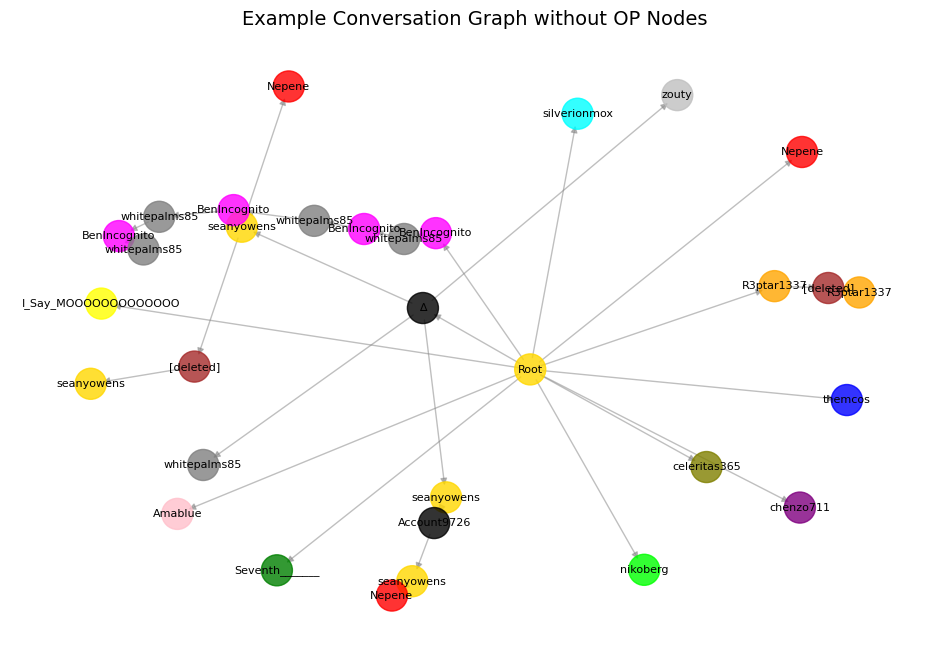

In [59]:
# Example graph with no op
root = train_processed_reduced[0]
example_graph = build_basic_graph(root, train_processed_reduced[0]["comments"])

print('Example graph with no op nodes:', example_graph.nodes())
print('Example graph with no op edges:', example_graph.edges())

visualize_graph_with_author_colors_and_labels(example_graph, title='Example Conversation Graph without OP Nodes')

Example graph with no op nodes: ['2ro9ux', 'cnhplrm', 'cnhrvq7', 'cnhz66d', 'cniauhy', 'cnibfev', 'cnhpsmr', 'cnhpvqs', 'cnhq7iw', 'cnhqrw1', 'cnhqzsf', 'cni8tcx', 'cnhpp4o', 'cnhqouu', 'cnhrd8u', 'cnhrwsq', 'cnhs6sc', 'cnhtr4t', 'cnhuopi', 'cnio1bg', 'cnhq330', 'cnhs7xb', 'cnhpnmr', 'cnhqhxa', 'cnhrkoc', 'cnhq7nv', 'cnhqcwz', 'cnhsyft', 'cnhww76', 'cnhz5wq', 'cni80dr', 'cni8e2y']
Example graph with no op edges: [('2ro9ux', 'cnhplrm'), ('2ro9ux', 'cnhpp4o'), ('2ro9ux', 'cnhq330'), ('2ro9ux', 'cnhs7xb'), ('2ro9ux', 'cnhpnmr'), ('2ro9ux', 'cnhq7nv'), ('2ro9ux', 'cnhqcwz'), ('2ro9ux', 'cnhsyft'), ('2ro9ux', 'cnhww76'), ('2ro9ux', 'cnhz5wq'), ('2ro9ux', 'cni80dr'), ('2ro9ux', 'cni8e2y'), ('2ro9ux', 'cnhuopi'), ('2ro9ux', 'cnhq7iw'), ('2ro9ux', 'cnhpsmr'), ('2ro9ux', 'cnhrd8u'), ('2ro9ux', 'cnio1bg'), ('2ro9ux', 'cnhpvqs'), ('2ro9ux', 'cni8tcx'), ('2ro9ux', 'cnhs6sc'), ('2ro9ux', 'cniauhy'), ('2ro9ux', 'cnhz66d'), ('2ro9ux', 'cnhqouu'), ('2ro9ux', 'cnhrvq7'), ('2ro9ux', 'cnhqzsf'), ('2ro9ux

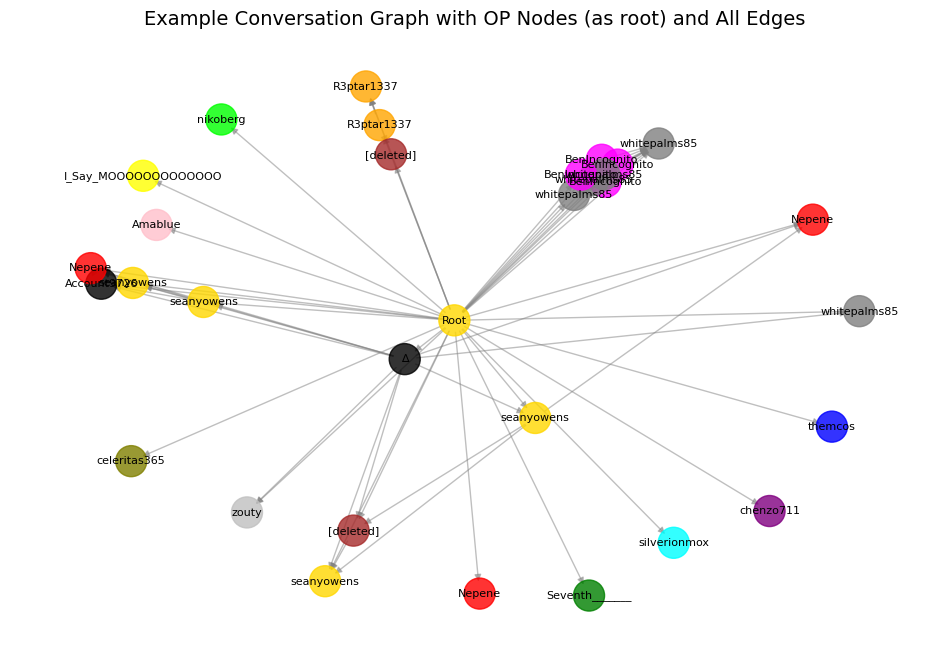

In [61]:
# Example graph with no op
root = train_processed_reduced[0]
example_graph = build_basic_graph(root, train_processed_reduced[0]["comments"], all_edges=True)

print('Example graph with no op nodes:', example_graph.nodes())
print('Example graph with no op edges:', example_graph.edges())

visualize_graph_with_author_colors_and_labels(example_graph, title='Example Conversation Graph with OP Nodes (as root) and All Edges')

In [63]:
# Build graphs for all conversations in the training data
conversation_graphs_train = []
for record in tqdm(train_processed_reduced):
    conversation_graphs_train.append(build_basic_graph(record, record["comments"], all_edges=True))

# Build graphs for all conversations in the test data
conversation_graphs_test = []
for record in tqdm(test_processed_reduced):
    conversation_graphs_test.append(build_basic_graph(record, record["comments"], all_edges=True))

len(conversation_graphs_train), len(conversation_graphs_test)

100%|██████████| 542/542 [00:02<00:00, 247.34it/s]


(2509, 542)

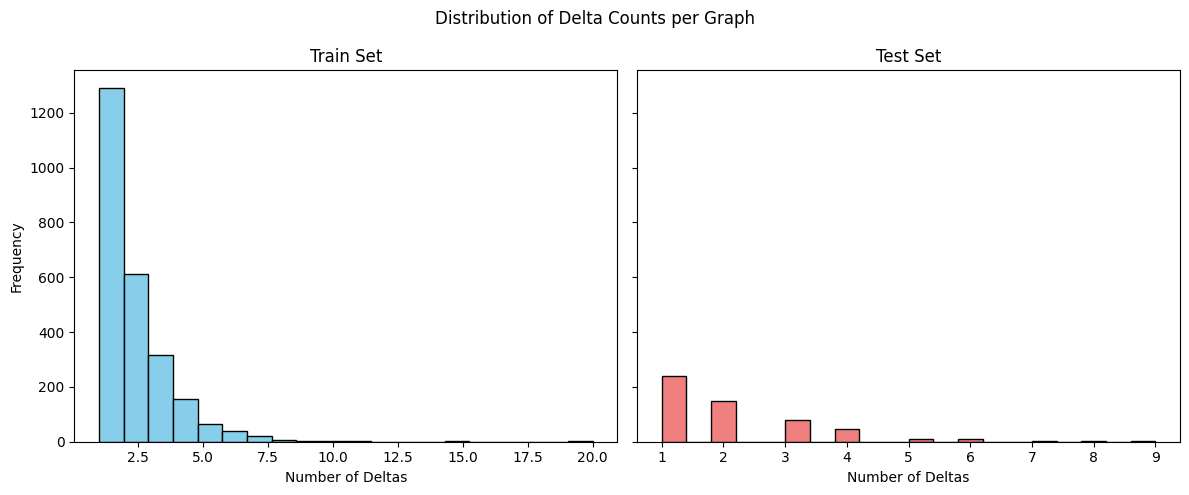

In [64]:
# Plot delta count distribution
plot_delta_distribution(conversation_graphs_train, conversation_graphs_test)

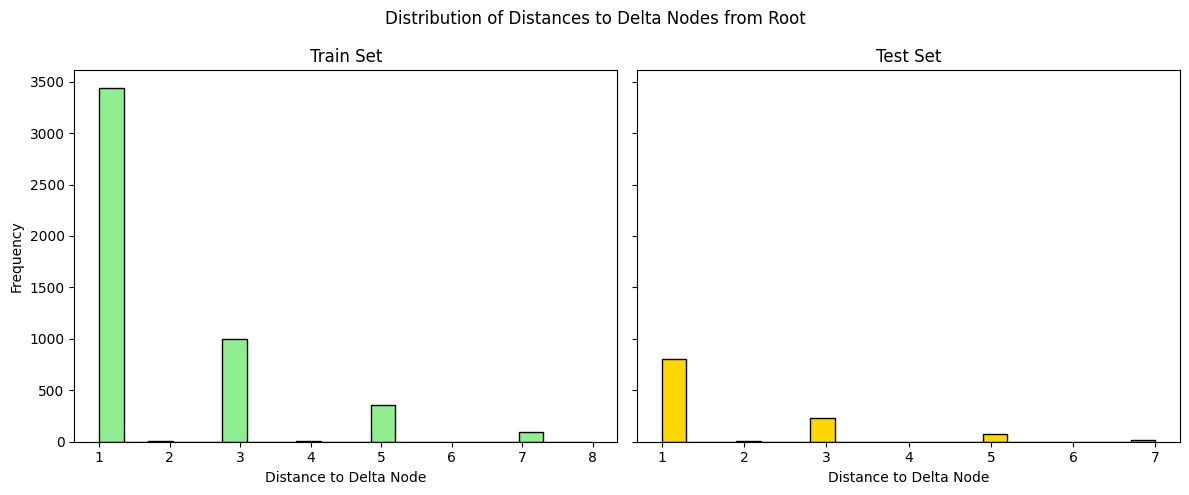

In [65]:
# Plot delta distance distribution
plot_delta_distance_distribution(conversation_graphs_train, conversation_graphs_test)

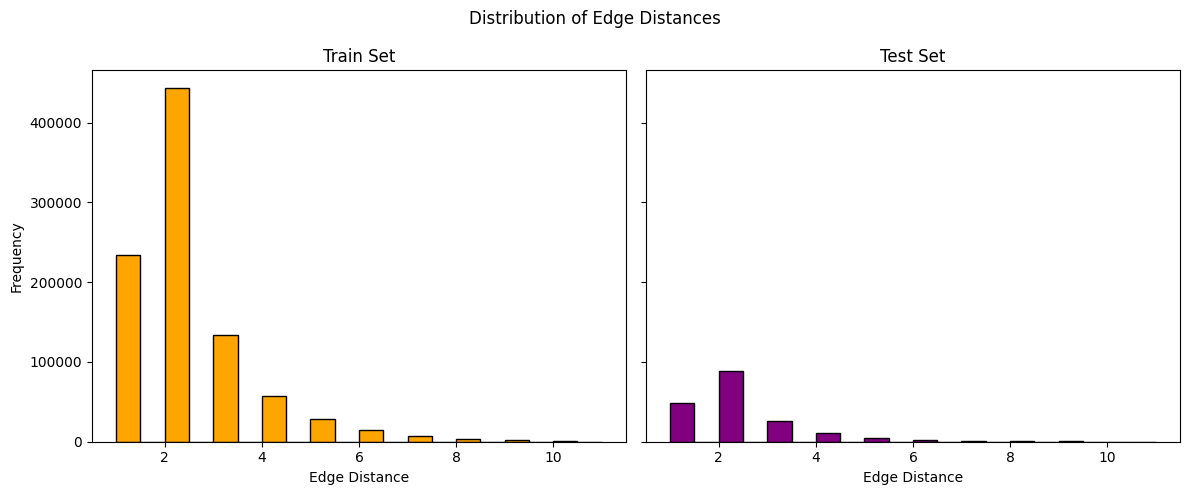

In [66]:
# Plot edge distance distribution
plot_edge_distance_distribution(conversation_graphs_train, conversation_graphs_test)

# Text Embedding + Data loaders

In [51]:
# Feature Extraction - BERT Embeddings
def generate_bert_embeddings(texts, tokenizer, model, device):
    """Generate embeddings for a list of texts using BERT."""
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

In [52]:
# Load pre-trained BERT
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")
bert_model = bert_model.to(device)

Using CUDA


In [53]:
def build_node_to_idx(graphs):
    """
    Create a global mapping from node IDs to numerical indices.
    """
    node_to_idx = {}
    idx = 0
    for graph in graphs:
        for node in graph.nodes:
            if node not in node_to_idx:
                node_to_idx[node] = idx
                idx += 1
    return node_to_idx

In [207]:
# node_to_idx = build_node_to_idx(conversation_graphs_train + conversation_graphs_test)
with open(f"{root_dir}/embedding/node_to_idx.json", "r") as f:
    node_to_idx = json.load(f)

len(node_to_idx)

In [73]:
def generate_embeddings_from_graph(graph, tokenizer, model,  device):
    """
    Generate embeddings for each node's text and its corresponding OP text.
    """
    node_embeddings = {}
    op_embeddings = {}
    
    for node, data in graph.nodes(data=True):
        # Text for the node
        node_text = data.get("text", "")
        op_text = data.get("root_body", "")

        # Generate embeddings
        node_embedding = generate_bert_embeddings([node_text], tokenizer, model, device).squeeze(0)
        op_embedding = generate_bert_embeddings([op_text], tokenizer, model, device).squeeze(0)

        node_embeddings[node] = node_embedding
        op_embeddings[node] = op_embedding

    return node_embeddings, op_embeddings

def generate_embeddings_for_all_graphs(graphs, tokenizer, model, node_to_idx, device):
    """
    Generate embeddings for all graphs using the global node-to-index mapping.
    Optimized to generate the OP embedding only once per graph.
    """
    embeddings = torch.zeros(len(node_to_idx), model.config.hidden_size, device=device)
    op_embeddings = torch.zeros(len(node_to_idx), model.config.hidden_size, device=device)

    for graph in tqdm(graphs, desc="Generating embeddings"):
        # Generate the OP embedding once for the entire graph
        root_body = list(graph.nodes(data=True))[0][1].get("root_body", "")  # Assuming root_body is the same for all nodes in the graph
        graph_op_embedding = generate_bert_embeddings([root_body], tokenizer, model, device).squeeze(0)

        for node, data in graph.nodes(data=True):
            node_idx = node_to_idx[node]
            node_text = data.get("text", "")

            # Generate node embedding
            node_embedding = generate_bert_embeddings([node_text], tokenizer, model, device).squeeze(0)

            # Store embeddings
            embeddings[node_idx] = node_embedding
            op_embeddings[node_idx] = graph_op_embedding

    return embeddings, op_embeddings

In [208]:
sample_train_data = conversation_graphs_train[:20]
sample_test_data = conversation_graphs_test[:10]

In [209]:
train_node_embeddings, train_op_embeddings = generate_embeddings_for_all_graphs(
    sample_train_data, bert_tokenizer, bert_model, node_to_idx, device
)

test_node_embeddings, test_op_embeddings = generate_embeddings_for_all_graphs(
    sample_test_data, bert_tokenizer, bert_model, node_to_idx, device
)


Generating embeddings:   0%|          | 0/20 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


In [ ]:
# Save the embeddings to disk
torch.save(train_node_embeddings, "train_node_embeddings.pt")
torch.save(train_op_embeddings, "train_op_embeddings.pt")
torch.save(test_node_embeddings, "test_node_embeddings.pt")
torch.save(test_op_embeddings, "test_op_embeddings.pt")

In [127]:
class GraphPerBatchDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, node_embeddings, op_embeddings, labels, global_node_to_idx):
        """
        Dataset where each batch corresponds to a single graph.
        """
        self.graphs = graphs
        self.node_embeddings = node_embeddings
        self.op_embeddings = op_embeddings
        self.labels = labels
        self.global_node_to_idx = global_node_to_idx

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph = self.graphs[idx]

        # Extract nodes and edges from the graph
        graph_nodes = list(graph.nodes)

        # Map global indices to local indices
        local_node_to_idx = {node: i for i, node in enumerate(graph_nodes)}
        batch_indices = [self.global_node_to_idx[node] for node in graph_nodes]

        # Map edges from global to local indices
        edge_index = torch.tensor(
            [
                [local_node_to_idx[src], local_node_to_idx[dst]]
                for src, dst in graph.edges
            ],
            dtype=torch.long,
        ).t().contiguous()

        # Extract edge attributes (e.g., distance)
        edge_attr = torch.tensor(
            [graph[src][dst]["distance"] for src, dst in graph.edges],
            dtype=torch.float,
        ).unsqueeze(1)  # Shape: [num_edges, 1]

        node_types = torch.tensor(
            [graph.nodes[node]["node_type"] for node in graph_nodes],
            dtype=torch.long,
        )  # Assign 1 for "predict" and 0 for "author" for op nodes

        # Prepare features and labels
        embeddings = self.node_embeddings[batch_indices]
        op_feats = self.op_embeddings[batch_indices]
        graph_labels = torch.tensor([self.labels[node] for node in graph_nodes], dtype=torch.long)

        # Create a `Data` object for the graph
        return Data(x=embeddings, edge_index=edge_index, edge_attr=edge_attr, op=op_feats, node_type=node_types, y=graph_labels)

In [210]:
# Generate labels for graph nodes
labels = {
    comment_id: comment["delta"] if comment["delta"] is not None else 0
    for comment_id, comment in all_comments.items()
}

In [211]:
# Create datasets
train_dataset = GraphPerBatchDataset(
    graphs=sample_train_data,
    node_embeddings=train_node_embeddings,
    op_embeddings=train_op_embeddings,
    labels=labels,
    global_node_to_idx=node_to_idx,
)

val_dataset = GraphPerBatchDataset(
    graphs=sample_test_data,
    node_embeddings=test_node_embeddings,
    op_embeddings=test_op_embeddings,
    labels=labels,
    global_node_to_idx=node_to_idx,
)

test_dataset = GraphPerBatchDataset(
    graphs=sample_test_data,
    node_embeddings=test_node_embeddings,
    op_embeddings=test_op_embeddings,
    labels=labels,
    global_node_to_idx=node_to_idx,
)

# Create dataloaders
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=1, shuffle=True),
    "val": DataLoader(val_dataset, batch_size=1),
    "test": DataLoader(test_dataset, batch_size=1),
}

In [212]:
for split, loader in dataloaders.items():
    print(f"{split.capitalize()} DataLoader:")
    for batch in loader:
        print(batch)
        break


Train DataLoader:
DataBatch(x=[145, 768], edge_index=[2, 468], edge_attr=[468, 1], y=[145], op=[145, 768], node_type=[145], batch=[145], ptr=[2])
Val DataLoader:
DataBatch(x=[121, 768], edge_index=[2, 411], edge_attr=[411, 1], y=[121], op=[121, 768], node_type=[121], batch=[121], ptr=[2])
Test DataLoader:
DataBatch(x=[121, 768], edge_index=[2, 411], edge_attr=[411, 1], y=[121], op=[121, 768], node_type=[121], batch=[121], ptr=[2])


# GNN + Baseline

**Approach 1: EdgeWeightedGNN**

EdgeWeightedGNN is a graph neural network that learns edge-specific weights to enhance message propagation. It uses learnable Multi-Layer Perceptrons (MLPs) to transform both node features and edge attributes independently for each layer. The model leverages these transformed edge weights during the message passing process.

**Approach 2: DistanceWeightedGNN**

DistanceWeightedGNN uses predefined edge weights based on the distance attribute, computed as 
1 / (distance + 1). It utilizes two GCN layers for feature propagation and aggregation, followed by a projection step to align the final embedding size.

**Approach 3: BaselineNodeClassifier**

BaselineNodeClassifier is a simple feedforward neural network that directly processes node embeddings and OP embeddings. It does not rely on graph-based propagation or edge attributes, treating each node independently.

In [240]:
from torch_geometric.nn import MessagePassing

# Approach 1: Learnable Transformation for Edge Weights
class EdgeWeightedGNN(MessagePassing):
    def __init__(self, in_channels, op_channels, out_channels, num_layers=2, hidden_dim=64, dropout=0.2):
        super(EdgeWeightedGNN, self).__init__(aggr="add")  # Aggregation type
        self.num_layers = num_layers
        self.node_mlp = torch.nn.ModuleList(
            [torch.nn.Linear(in_channels if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)]
        )
        self.edge_mlp = torch.nn.ModuleList(
            [torch.nn.Linear(1, hidden_dim) for _ in range(num_layers)]  # One for each layer
        )
        self.projection = torch.nn.Linear(hidden_dim, in_channels)  # Project back to initial embedding size
        self.fc = torch.nn.Linear(in_channels + op_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, batch, return_embeddings=False):
        x = batch.x
        edge_index = batch.edge_index
        edge_attr = batch.edge_attr

        for i in range(self.num_layers):
            # Transform node features
            x = self.node_mlp[i](x)
            x = F.relu(x)
            x = self.dropout(x)

            # Transform edge attributes
            edge_weight = self.edge_mlp[i](edge_attr)

            # Message passing
            x = self.propagate(edge_index, x=x, edge_weight=edge_weight)

        # Project embeddings back to initial embedding size
        final_embeddings = self.projection(x)

        if return_embeddings:
            return final_embeddings  # Return node embeddings only

        # Concatenate OP embedding before the linear layer
        x = torch.cat([final_embeddings, batch.op], dim=1)
        x = self.fc(x)
        return x

    def message(self, x_j, edge_weight):
        return x_j * edge_weight  # Scale source node features by edge weight

# Approach 2: Predefined Distance Decay for Edge Weights
class DistanceWeightedGNN(torch.nn.Module):
    def __init__(self, in_channels, op_channels, out_channels, dropout=0.2):
        super(DistanceWeightedGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, 64)
        self.projection = torch.nn.Linear(64, in_channels)  # Project back to initial embedding size
        self.fc = torch.nn.Linear(in_channels + op_channels, out_channels)  # Adjust size
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, batch, return_embeddings=False):
        # Compute edge weights using distance
        edge_weight = 1 / (batch.edge_attr + 1)  # Distance decay function

        # Apply GNN layers
        x = self.conv1(batch.x, batch.edge_index, edge_weight=edge_weight.squeeze())
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, batch.edge_index, edge_weight=edge_weight.squeeze())
        x = F.relu(x)
        x = self.dropout(x)

        # Project embeddings back to initial embedding size
        final_embeddings = self.projection(x)

        if return_embeddings:
            return final_embeddings  # Return node embeddings only

        # Concatenate OP embedding before the linear layer
        x = torch.cat([final_embeddings, batch.op], dim=1)
        x = self.fc(x)
        return x
    
# Approach 3: Baseline Node Classifier
class BaselineNodeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1):
        super(BaselineNodeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)  # For classification

    def forward(self, data):
        # Concatenate the initial node embedding (x) and the op embedding
        inputs = torch.cat((data.x, data.op), dim=1)
        x = self.fc1(inputs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.softmax(x)


In [215]:
def plot_loss(train_losses, val_losses, results_dir="results"):
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(f"{results_dir}/loss_curve.png")
    plt.close()
    
def plot_roc(fpr, tpr, roc_auc, results_dir="results"):
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.savefig(f"{results_dir}/roc_curve.png")
    plt.close()

In [216]:
def mask_author_nodes(predictions, labels, node_types):
    # Create a mask to exclude author nodes
    mask = (node_types != 0).to(torch.bool)

    # Apply the mask to predictions and labels
    predictions = predictions[mask]
    labels = labels[mask]
    return predictions, labels

def train_and_evaluate_model(
    model, dataloaders, epochs=10, lr=0.01, class_weights=None, weight_decay=0.0, device="cpu", patience=20
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model = model.to(device)

    # Use class weights in the loss function
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    train_losses, val_losses = [], []

    best_val_loss = float("inf")  # Initialize the best validation loss
    best_model_state = None       # Variable to store the best model state
    epochs_without_improvement = 0  # Counter for early stopping

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in dataloaders["train"]:
            batch = batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            out = model(batch)

            predictions_masked, labels_masked = mask_author_nodes(out, batch.y, batch.node_type)
            loss = loss_fn(predictions_masked, labels_masked)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch in dataloaders["val"]:
                batch = batch.to(device)
                out = model(batch)
                predictions_masked, labels_masked = mask_author_nodes(out, batch.y, batch.node_type)
                loss = loss_fn(predictions_masked, labels_masked)
                val_loss += loss.item()

            val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the model if this is the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the model's state
            epochs_without_improvement = 0  # Reset the counter
        else:
            epochs_without_improvement += 1

        # Check for early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    print(f"Best Validation Loss: {best_val_loss:.4f}")
    return train_losses, val_losses, best_model_state

def evaluate_model_on_test(model, dataloader, results_dir="results", device="cpu"):
    model.eval()
    model = model.to(device)  # Ensure model is on the correct device
    with torch.no_grad():
        all_preds, all_labels, all_probs = [], [], []

        for batch in dataloader:
            batch = batch.to(device)
            out = model(batch)

            # Extract predictions, probabilities, and labels
            probs = torch.softmax(out, dim=1)[:, 1]  # Probabilities for the positive class
            preds = out.argmax(dim=1)
            labels = batch.y

            # Mask author nodes using your mask function
            probs_masked, labels_masked = mask_author_nodes(probs, labels, batch.node_type)
            preds_masked, _ = mask_author_nodes(preds, labels, batch.node_type)

            # Convert to numpy for metric calculations
            all_probs.extend(probs_masked.cpu().numpy())
            all_preds.extend(preds_masked.cpu().numpy())
            all_labels.extend(labels_masked.cpu().numpy())

        # Calculate metrics
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        roc_auc = roc_auc_score(all_labels, all_probs)  # Calculate ROC-AUC score
        print(f"Test Accuracy: {acc:.4f}, Test F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", values_format="d")

        # Save Confusion Matrix
        plt.title("Confusion Matrix")
        plt.savefig(f"{results_dir}/confusion_matrix.png")
        plt.close()

        # Classification Report
        report = classification_report(all_labels, all_preds, target_names=["Negative", "Positive"])
        print(report)

        # Save Classification Report
        with open(f"{results_dir}/classification_report.txt", "w") as f:
            f.write(report)

        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        plot_roc(fpr, tpr, roc_auc, results_dir=results_dir)

In [217]:
def calculate_class_weights(dataloader):
    """
    Calculate class weights for the training dataset.
    """
    all_labels = []
    for batch in dataloader:
        all_labels.extend(batch.y.cpu().numpy())

    # Convert class labels to NumPy array
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),  # Convert classes to NumPy array
        y=np.array(all_labels)    # Convert labels to NumPy array
    )
    return torch.tensor(class_weights, dtype=torch.float).to(device)

train_class_weights = calculate_class_weights(dataloaders["train"])
print(f"Class Weights: {train_class_weights}")

Class Weights: tensor([ 0.5082, 30.9231], device='cuda:0')


In [241]:
# Define hyperparameters
learning_rates = [0.001] # , 0.0001
num_epochs = [5] # ,50, 200  
weight_decay_values = [1e-5] # , 1e-3
dropout_rates = [0.1] # , 0.3
model_types = ["distance_weighted_gnn", "edge_weighted_gnn", "baseline"]

# Variables to track the best model for each type
best_val_loss_by_model = {model_type: float('inf') for model_type in model_types}
best_hyperparams_by_model = {model_type: None for model_type in model_types}
best_model_state_by_model = {model_type: None for model_type in model_types}

# Iterate over combinations
for model_type, lr, epochs, weight_decay, dropout in tqdm(product(model_types, learning_rates, num_epochs, weight_decay_values, dropout_rates)):
    print(f"Training with model: {model_type}, lr: {lr}, epochs: {epochs}, l1: {weight_decay}, dropout: {dropout}")

    results_dir = f'{root_dir}/results/{model_type}'
    os.makedirs(results_dir, exist_ok=True)

    # Create a subdirectory for the current hyperparameters
    hyperparam_dir = f"{results_dir}/lr_{lr}_epochs_{epochs}_l1_{weight_decay}_dropout_{dropout}"
    # if os.path.exists(hyperparam_dir):
    #     continue

    os.makedirs(hyperparam_dir, exist_ok=True)

    if model_type == "distance_weighted_gnn":
        model = DistanceWeightedGNN(
            in_channels=train_dataset[0].x.shape[1],
            op_channels=train_dataset[0].op.shape[1],
            out_channels=2,
            dropout=dropout
        )
    elif model_type == "edge_weighted_gnn":
        model = EdgeWeightedGNN( 
            in_channels=train_dataset[0].x.shape[1],
            op_channels=train_dataset[0].op.shape[1],
            out_channels=2,
            dropout=dropout
        )
    elif model_type == "baseline":
        input_dim = train_dataset[0].x.shape[1] + train_dataset[0].op.shape[1]
        hidden_dim = 256
        output_dim = 2
        model = BaselineNodeClassifier(input_dim, hidden_dim, output_dim, dropout=dropout)

    # Train and evaluate
    train_losses, val_losses, model_best_val = train_and_evaluate_model(
        model, dataloaders, epochs=epochs, lr=lr, class_weights=train_class_weights, weight_decay=weight_decay, device=device
    )

    torch.save(model_best_val, f"{hyperparam_dir}/model_state.pth")

    # Track the best model for the current model type based on validation loss
    avg_val_loss = sum(val_losses) / len(val_losses)
    if avg_val_loss < best_val_loss_by_model[model_type]:
        best_val_loss_by_model[model_type] = avg_val_loss
        best_model_state_by_model[model_type] = model_best_val
        best_hyperparams_by_model[model_type] = {"lr": lr, "epochs": epochs, "l1_lambda": weight_decay, "dropout": dropout}

    # Plot and save losses for the current model
    plot_loss(train_losses, val_losses, hyperparam_dir)
    evaluate_model_on_test(model, dataloaders["test"], results_dir=hyperparam_dir, device=device)

0it [00:00, ?it/s]

Training with model: distance_weighted_gnn, lr: 0.001, epochs: 5, l1: 1e-05, dropout: 0.1
Epoch 1, Train Loss: 14.9425, Val Loss: 6.8735
Epoch 2, Train Loss: 13.6940, Val Loss: 6.6276
Epoch 3, Train Loss: 13.0492, Val Loss: 6.5403
Epoch 4, Train Loss: 12.2639, Val Loss: 6.1306
Epoch 5, Train Loss: 11.5585, Val Loss: 6.2406
Best Validation Loss: 6.1306
Test Accuracy: 0.7418, Test F1: 0.0753, ROC-AUC: 0.7656
              precision    recall  f1-score   support

    Negative       0.98      0.75      0.85       837
    Positive       0.04      0.47      0.08        19

    accuracy                           0.74       856
   macro avg       0.51      0.61      0.46       856
weighted avg       0.96      0.74      0.83       856



1it [00:01,  1.50s/it]

Training with model: edge_weighted_gnn, lr: 0.001, epochs: 5, l1: 1e-05, dropout: 0.1
Epoch 1, Train Loss: 14.4600, Val Loss: 7.3337
Epoch 2, Train Loss: 12.1229, Val Loss: 5.8489
Epoch 3, Train Loss: 11.0689, Val Loss: 5.7809
Epoch 4, Train Loss: 10.3599, Val Loss: 6.1322
Epoch 5, Train Loss: 10.0768, Val Loss: 5.8005
Best Validation Loss: 5.7809


2it [00:05,  3.00s/it]

Test Accuracy: 0.4661, Test F1: 0.0692, ROC-AUC: 0.7351
              precision    recall  f1-score   support

    Negative       0.99      0.46      0.63       837
    Positive       0.04      0.89      0.07        19

    accuracy                           0.47       856
   macro avg       0.52      0.68      0.35       856
weighted avg       0.97      0.47      0.61       856

Training with model: baseline, lr: 0.001, epochs: 5, l1: 1e-05, dropout: 0.1
Epoch 1, Train Loss: 13.7442, Val Loss: 6.5065
Epoch 2, Train Loss: 12.6196, Val Loss: 6.5396
Epoch 3, Train Loss: 11.8264, Val Loss: 5.8360
Epoch 4, Train Loss: 11.0518, Val Loss: 6.2460
Epoch 5, Train Loss: 10.3090, Val Loss: 8.5230
Best Validation Loss: 5.8360
Test Accuracy: 0.9743, Test F1: 0.0000, ROC-AUC: 0.8133
              precision    recall  f1-score   support

    Negative       0.98      1.00      0.99       837
    Positive       0.00      0.00      0.00        19

    accuracy                           0.97       856
  

3it [00:06,  2.14s/it]


In [235]:
# Save the best hyperparameters and models for each model type
for model_type in model_types:
    best_hyperparams_dir = f"{root_dir}/results/{model_type}/best_hyperparams"
    os.makedirs(best_hyperparams_dir, exist_ok=True)

    with open(f"{best_hyperparams_dir}/best_hyperparams.txt", "w") as f:
        f.write(f"Best Hyperparameters: {best_hyperparams_by_model[model_type]}\n")
        f.write(f"Validation Loss: {best_val_loss_by_model[model_type]:.4f}\n")

    torch.save(best_model_state_by_model[model_type], f"{best_hyperparams_dir}/best_model.pth")

    # Re-initialize the model with the best hyperparameters
    if model_type == "distance_weighted_gnn":
        best_model = DistanceWeightedGNN(
            in_channels=train_dataset[0].x.shape[1],
            op_channels=train_dataset[0].op.shape[1],
            out_channels=2,
            dropout=best_hyperparams_by_model[model_type]["dropout"]
        )
    elif model_type == "edge_weighted_gnn":
        best_model = EdgeWeightedGNN(
            in_channels=train_dataset[0].x.shape[1],
            op_channels=train_dataset[0].op.shape[1],
            out_channels=2,
            dropout=best_hyperparams_by_model[model_type]["dropout"]
        )
    elif model_type == "baseline":
        input_dim = train_dataset[0].x.shape[1] + train_dataset[0].op.shape[1]
        hidden_dim = 256
        output_dim = 2
        best_model = BaselineNodeClassifier(
            input_dim, hidden_dim, output_dim,
            dropout=best_hyperparams_by_model[model_type]["dropout"]
        )

    # Load the best model's state
    best_model.load_state_dict(best_model_state_by_model[model_type])
    best_model = best_model.to(device) 

    # Evaluate on the test set 
    evaluate_model_on_test(best_model, dataloaders["test"], results_dir=best_hyperparams_dir, device=device)

Test Accuracy: 0.4650, Test F1: 0.0766, ROC-AUC: 0.7605
              precision    recall  f1-score   support

    Negative       1.00      0.45      0.62       837
    Positive       0.04      1.00      0.08        19

    accuracy                           0.46       856
   macro avg       0.52      0.73      0.35       856
weighted avg       0.98      0.46      0.61       856

Test Accuracy: 0.4019, Test F1: 0.0623, ROC-AUC: 0.7368
              precision    recall  f1-score   support

    Negative       0.99      0.39      0.56       837
    Positive       0.03      0.89      0.06        19

    accuracy                           0.40       856
   macro avg       0.51      0.64      0.31       856
weighted avg       0.97      0.40      0.55       856

